# Self Implementation of Vanilla GAN
Paper: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
import torch
torch.cuda.is_available()


True

array2gif allows making gifs from numpy arrays

In [2]:
!pip install array2gif

In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import torchvision

class Generator(nn.Module):
    def __init__(self, latent_size = 100):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model       = nn.Sequential(nn.Linear(latent_size, 6*6),
                                         nn.ReLU(),
                                         nn.Linear(6*6, 12*12),
                                         nn.ReLU(),
                                         nn.Linear(12*12, 28*28),
                                         nn.Tanh()
                                         )
    def __call__(self, latent):
        return self.forward(latent)

    def forward(self, latent):
        gen = self.model(latent)
        gen = gen.view((gen.size()[0],*(1,28,28)))
        return gen


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(nn.Linear(28*28, 12*12),
                              nn.ReLU(),
                              nn.Linear(12*12, 6*6),
                              nn.ReLU(),
                              nn.Linear(6*6, 1),
                              nn.Sigmoid()
                              )
    def __call__(self, img):
        return self.forward(img)

    def forward(self, img):
        flattened = img.view(img.size()[0], -1)
        decision = self.model(flattened.cuda())
        return decision


Function to plot results every now and then just for being sure everything is fine

In [5]:
def plot_epoch(images, n=36):
    '''
    Visualize a single epoch of images

    Parameters
    ----------
    images : numpy.ndarray
             images of shape (b, c, x, y)
    n      : int, default: 36
             number of images to display. Must be a square number
    '''

    if not isinstance(images, np.ndarray):
        images = images.detach().numpy()

    rowcols = np.sqrt(n)
    plt.figure(figsize=(rowcols, rowcols))
    for index in range(n):
        plt.subplot(rowcols, rowcols, index + 1)
        plt.imshow(images[index, 0, :, :], cmap="binary")
        plt.axis("off")
    plt.show()


In [6]:
from torch.optim import Adam
from torchvision.datasets import MNIST
from array2gif import write_gif

LATENT_SIZE = 100
EPOCH_SIZE  = 300
ROW_NUM     = 6
try:
  data_path = os.path.join(os.path.abspath(os.environ["CONDA_PREFIX"]),
                          'datasets')
except KeyError:
    data_path = os.path.join(os.path.abspath(os.environ["HOME"]),
                         'datasets')
# We make sure that the dataset is actually available
try:
    torchvision.datasets.MNIST(root=data_path,
                               download=False)
except RuntimeError or KeyError:
    if not os.path.isdir(data_path):
            os.makedirs(data_path)
    torchvision.datasets.MNIST(root=data_path,
                               download=True)


dataset = torchvision.datasets.MNIST(root=data_path,download=True)
dataset.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize(mean = (0.5,),
                                                                                     std = (0.5,))])


# Data Loader
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last=True)
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is: " + str(device))

criterion = nn.BCELoss()

discriminator = Discriminator().to(device)
generator     = Generator().to(device)

optim_d = Adam(discriminator.parameters(), lr = 0.0002)
optim_g = Adam(generator.parameters(),     lr = 0.0002)

gif_array = []*EPOCH_SIZE
total_step = len(data_loader)
for epoch in range(EPOCH_SIZE):
    for step, (imgs, _) in enumerate(data_loader):

        # Create Fake and Real Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        outputs     = discriminator(imgs)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # BCE on fake images
        lat_space   = torch.randn(batch_size, LATENT_SIZE).to(device)
        fake_images = generator(lat_space)
        outputs     = discriminator(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score  = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        optim_d.zero_grad()
        optim_g.zero_grad()
        d_loss.backward()
        optim_d.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        lat_space = torch.randn(batch_size, LATENT_SIZE).to(device)
        fake_images = generator(lat_space)
        outputs = discriminator(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        optim_d.zero_grad()
        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

        if (step+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                    .format(epoch, EPOCH_SIZE,
                            step+1, total_step,
                            d_loss.item(),
                            g_loss.item(),
                            real_score.mean().item(),
                            fake_score.mean().item()))
    # plot_epoch(fake_images.cpu())
    array_2_make_grid = ((fake_images.cpu()[0:ROW_NUM**2, :, :, :] + 1) * (1/2) * 255).type(torch.uint8)
    gif_array.append(torchvision.utils.make_grid(array_2_make_grid, nrow = ROW_NUM).numpy())
write_gif(gif_array, filename = 'vanilla_10_fps.gif', fps = 10)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.6MB/s]


Device is: cuda
Epoch [0/300], Step [200/468], d_loss: 0.4350, g_loss: 1.4595, D(x): 0.91, D(G(z)): 0.28
Epoch [0/300], Step [400/468], d_loss: 1.0629, g_loss: 0.7765, D(x): 0.77, D(G(z)): 0.53
Epoch [1/300], Step [200/468], d_loss: 0.1727, g_loss: 2.5631, D(x): 0.95, D(G(z)): 0.11
Epoch [1/300], Step [400/468], d_loss: 1.1835, g_loss: 1.6550, D(x): 0.66, D(G(z)): 0.44
Epoch [2/300], Step [200/468], d_loss: 0.1483, g_loss: 3.3558, D(x): 0.93, D(G(z)): 0.06
Epoch [2/300], Step [400/468], d_loss: 0.8825, g_loss: 1.3820, D(x): 0.76, D(G(z)): 0.37
Epoch [3/300], Step [200/468], d_loss: 1.1328, g_loss: 1.5236, D(x): 0.58, D(G(z)): 0.29
Epoch [3/300], Step [400/468], d_loss: 0.0958, g_loss: 3.2778, D(x): 0.96, D(G(z)): 0.05
Epoch [4/300], Step [200/468], d_loss: 0.8100, g_loss: 1.5148, D(x): 0.72, D(G(z)): 0.29
Epoch [4/300], Step [400/468], d_loss: 1.5082, g_loss: 1.8873, D(x): 0.58, D(G(z)): 0.38
Epoch [5/300], Step [200/468], d_loss: 0.5920, g_loss: 2.2620, D(x): 0.79, D(G(z)): 0.22
Epoch

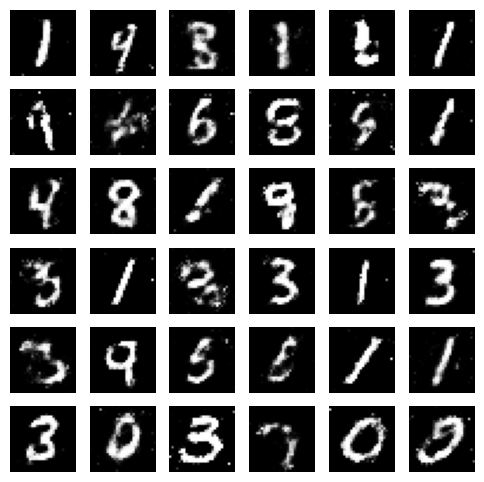

In [7]:
# Generar nuevas imágenes después del entrenamiento
import matplotlib.pyplot as plt
import numpy as np

# Tomar 36 vectores aleatorios del espacio latente
latent = torch.randn(36, 100).to('cuda')

# Generar imágenes
with torch.no_grad():
    generated = generator(latent).cpu()

# Convertir a numpy y visualizar
images = generated.detach().numpy()
rowcols = int(np.sqrt(36))

plt.figure(figsize=(rowcols, rowcols))
for index in range(36):
    plt.subplot(rowcols, rowcols, index + 1)
    plt.imshow(images[index, 0, :, :], cmap="gray")
    plt.axis("off")
plt.show()
